In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./mnist/data/', one_hot = True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


- 위조지폐범(생성자)와 경찰(구분자)가 있다면, 위조지폐범은 경찰을 최대한 속이려고 노력하고, 경찰은 위조한 지폐를 최대한 감별하려고 노력하면, 언젠가는 결국 위조지폐범이 진짜와 거의 구분할 수 없는 위조지폐를 만들 수 있다는 것이다. 
- 먼저 실제 이미지를 주고 구분자에게 이미지가 진짜임을 판단하게 한다. 
- 그런 다음 생성자를 통해 노이즈로부터 임의의 이미지를 만들고 이것을 다시 같은 구분자를 통해 진짜 이미지인지 판단한다.
- 이렇게 생성자는 구분자를 속여 진짜처럼 보이게 하고, 구분자는 생성자가 만든 이미지를 최대한 가짜라고 구분하도록 훈련하는 것이다. 
- 이렇게 생성자와 구분자의 경쟁을 통해 결과적으로 생성자는 실제 이미지와 상당히 비슷한 이미지를 생성하게 된다. 


In [2]:
total_epoch = 100
batch_size =100
learning_rate = 0.0002
n_hidden = 256
n_input = 28 *28
# 생성자의 입력값으로 사용할 노이즈의 크기
n_noise = 128


- 비지도 학습이므로 오토인코더와 같이 Y는 존재하지 않는다. 
- 구분자에 넣을 이미지가 실제 이미지와 생성한 가짜이미지 두 개이고, 가짜이미지는 노이즈에서 생성할 것으므로, 노이즈를 생성할 플레이스홀더가 필요하다.

In [22]:
X = tf.placeholder(tf.float32, [None, n_input])
# 가짜이미지는 노이지에서생성되므로 노이즈를 입력할 플레이스 홀더 추가
Z = tf.placeholder(tf.float32, [None, n_noise])

### 생성자( Generator)
- 생성자 신경망에 사용할 변수를 설정한다. 
- 첫 번째 가중치와 편향은 은닉층으로 출력하기 위한 변수들이고 
- 두 번째 가중치와 편향은 출력층에 사용할 변수들이다. 
- 따라서 두 번째 가중치의 변수 크기는 실제 이미지의 크기와 같아야 한다(n_input = 28 * 28 = 784)

In [23]:
with tf.device('/cpu:0'):
    G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev = 0.01))
    G_b1 = tf.Variable(tf.random_normal([n_hidden]))
    G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev = 0.01))
    G_b2 = tf.Variable(tf.random_normal([n_input]))

### 구분자(Discriminator)
- 구분자 신경망에 사용할 변수를 설정한다. 
- 은닉층은 생성자와 동일하게 구성하였다.
- 구분자는 진짜와 얼마나 가까운가를 판단하는 값으로, 0~1 사이의 값을 출력한다. (스칼라 출력)

In [24]:
with tf.device('/cpu:0'):
    D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev = 0.01))
    D_b1 = tf.Variable(tf.random_normal([n_hidden]))
    D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev = 0.01))
    D_b2 = tf.Variable(tf.random_normal([1]))

- 실제 이미지를 판별하는 구분자 신경망과 생성한 이미지를 판별하는 구분자 신경망은 같은 변수를 사용하여야 한다. 같은 신경망으로 구분을 시켜야 진짜 이미지와 가짜 이미지를 구분하는 특징들을 동시에 잡아낼 수 있기 때문이다. 

### 생성자 신경망
- 무작위로 생성한 노이즈를 받아 가중치와 편향을 반영하여 은닉층을 만들고, 은닉층에서 실제 이미지와 같은 크기의 결괏값을 출력하는 구성이다.

In [25]:
def generator(noise_z):
    with tf.device('/cpu:0'):
        hidden = tf.nn.relu(tf.matmul(noise_z, G_W1) + G_b1)
        output = tf.nn.sigmoid(tf.matmul(hidden, G_W2) + G_b2)
    return output

### 구분자 신경망
- 생성자 신경망과 같은 구성이지만, 0~1사이의 스칼라값 하나를 출력하도록 하였고, 이를 위한 활성화 함수로 sigmoid함수를 사용하였다. 

In [26]:
def discriminator(inputs):
    with tf.device('/cpu:0'):
        hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
        output = tf.nn.sigmoid(tf.matmul(hidden, D_W2) + D_b2)
    return output

- 무작위한 노이즈를 만들어주는 간단한 유틸리티 함수

In [27]:
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))

- 노이즈 Z를 이용해 가짜 이미지를 만들 생성자 G를 만들고, 이 G가 만든 가짜 이미지와 진짜 이미지 X를 각각 구분자에 넣어 입력한 이미지가 진짜인지를 판별하도록 한다. 

In [28]:
with tf.device('/cpu:0'):
    G = generator(Z)
    D_gene = discriminator(G)
    D_real = discriminator(X)

- 손실값은 두개가 필요하다. 
- 생성자가 만든 이미지를 구분자가 가짜라고 판단하도록 하는 손실값(경찰 학습용)
- 진짜라고 판단하도록 하는 손실값(위조지폐범 학습용)
- 경찰을 학습시키려면 
    - 진짜 이미지 판별값 D_real은 1에 가까워야 하고(진짜라고 판별)
    - 가짜 이미지 판별값 D_gene은 0에 가까워야 한다.(가짜라고 판별
- 간단하게 설명하면 D_real과 1 - D_gene 값을 더한 값을 손실값으로 하여 이 값을 최대화하면 경찰 학습이 이루어진다.

In [29]:
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1-D_gene))

- 위조 지폐범을 학습시키려면
    - 가짜 이미지 판별값 D_gene을 1에 가깝게 만들기만 하면 된다.
- 가짜 이미지를 넣어도 진짜같다고 판별해야 한다.
- 다음과 같이 D_gene를 그대로 넣어 이를 손실값으로 하고, 이 값을 최대화하면 위조지폐범 학습이 이루어진다. 

In [30]:
loss_G = tf.reduce_mean(tf.log(D_gene))

- GAN의 학습은 loss_D와 loss_G 모두를 최대화 하는 것이 목표이다.
- loss_D와 loss_G는 서로 연관되어 있어서 두 손실값이 항상 같이 증가하는 경향을 보이지 않는다. 
- loss_D가 증가하려면 loss_G는 하락해야 하고, 반대로 loss_G가 증가하려면 loss_D는 하락해야 하는 경쟁 관계이기 때문 

### 학습
- loss_D를 구할 때는 구분자 신경망에 사용되는 변수들만 사용하고
- loss_G를 구할 때는 생성자 신경망에 사용되는 변수들만 사용하여 최적화 해야한다. 
- 서로의 학습은 독립적으로 이루어져야 하기 때문이다. 

In [31]:
D_var_list = [D_W1, D_W2, D_b1, D_b2]
G_var_list = [G_W1, G_W2, G_b1, G_b2]

- GAN 논문에 따르면 loss를 최대화해야하지만, 최적화에 쓸 수 있는 함수는 minimize뿐이므로 loss_D와 loss_G에 음수를 취한다. 

In [32]:
with tf.device('/cpu:0'):
    train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list = D_var_list)
    train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list = G_var_list)

- 전과 마찬가지로 미니배치로 학습을 반복한다. 여기서 구분자는 X값을, 생성자는 노이즈인 Z값을 갖는다.
- 노이즈를 생성해주는 get_noise 함수를 통해 배치 크기만큼 노이즈를 만들고 이를 입력해준다. 

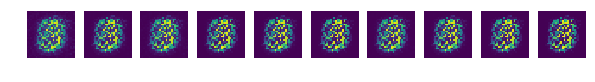

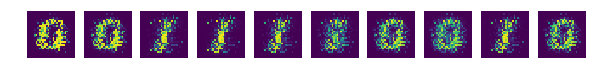

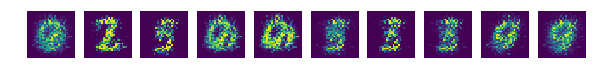

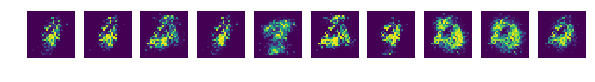

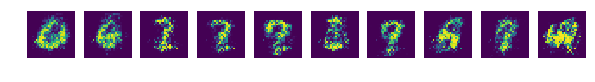

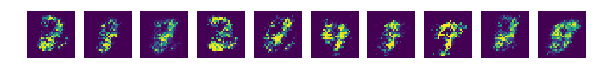

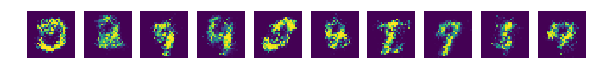

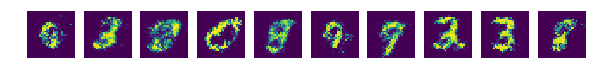

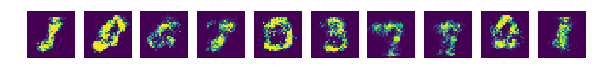

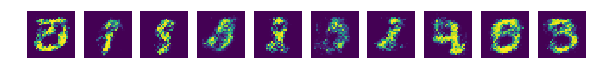

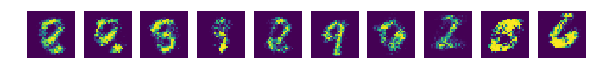

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D], feed_dict = {X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict = {X: batch_xs, Z: noise})
   # print('Epoch: {}\n D loss : {} \n G loss : {}'.format(epoch+1, loss_val_D, loss_val_G))
    # 학습이 잘되는지 0번째, 9번째 19번째 29번째 마다 생성기로 이미지를 생성하여 눈으로 직접 확인해본다.
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict = {Z: noise})
        fig, axes = plt.subplots(1, sample_size, figsize = (sample_size, 1))
        for i, ax in enumerate(axes):
            ax.set_axis_off()
            ax.imshow(np.reshape(samples[i], (28, 28)))
        plt.show()
        plt.savefig('./samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        

In [37]:
sess.close()